## Часть 2. Выравнивание лиц.

На этом этапе обучим нейросеть на поиск ключевых точек на лицах и обработаем изображения, полученные на первом этапе детекции. Из ключевых точек оставим только координаты зрачков, поскольку выравнивание будет осуществляться именно по ним

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torchvision.models as models

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
dataDir = '/kaggle/input/facial-keypoint-detection/'
outDir = '/kaggle/working/'
IMG_SIZE = 224
generator = torch.Generator().manual_seed(202)
BATCH_SIZE = 8

## Датасет и даталоадеры

In [4]:
transformer = transforms.Compose([transforms.ToTensor(),
                    transforms.Resize((IMG_SIZE,IMG_SIZE), antialias=True), 
                    transforms.Normalize(mean=[0.4897,0.4897,0.4897], std = [0.2330,0.2330,0.2330])
                                 ])

### Загрузка аннотаций из csv файла

In [5]:
annotations = pd.read_csv(dataDir + 'training.csv')

In [6]:
annotations = annotations.loc[:, ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y']]

In [7]:
annotations.isna().sum()

left_eye_center_x     10
left_eye_center_y     10
right_eye_center_x    13
right_eye_center_y    13
dtype: int64

In [8]:
annotations['idx1'] = annotations.index
annotations['im_name'] = annotations['idx1'].apply(lambda x: str(x) + '.jpg')
annotations.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,idx1,im_name
0,66.033564,39.002274,30.227008,36.421678,0,0.jpg
1,64.332936,34.970077,29.949277,33.448715,1,1.jpg
2,65.057053,34.909642,30.903789,34.909642,2,2.jpg
3,65.225739,37.261774,32.023096,37.261774,3,3.jpg
4,66.725301,39.621261,32.244810,38.042032,4,4.jpg


In [9]:
annotations = annotations.dropna().reset_index(drop=True)

In [10]:
annotations.shape

(7033, 6)

In [11]:
class Points(torch.utils.data.Dataset):
    def __init__(self, root, ann, size, transform):
        self.root = root
        self.ann = ann
        self.imgs = list(self.ann['im_name'])
        self.size = size
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.imgs[idx]))
        kx = self.size / img.size[0]
        ky = self.size / img.size[1]
        points = []
        w = kx * img.size[0]
        h = ky * img.size[1]
        lecx = self.ann.loc[idx]['left_eye_center_x'] * kx
        recx = self.ann.loc[idx]['right_eye_center_x'] * kx
        lecy = self.ann.loc[idx]['left_eye_center_y'] * ky
        recy = self.ann.loc[idx]['right_eye_center_y'] * ky
        points.append([lecx, recx, lecy, recy])
        points = torch.as_tensor(points, dtype=torch.float32).squeeze(0)
        

        return self.transform(img), points

    def __len__(self):
        return len(self.imgs)

In [12]:
marx = Points(dataDir + 'images/train_images/', annotations, IMG_SIZE, transformer)
len(marx)

7033

In [13]:
train, valid, test = torch.utils.data.random_split(marx, [.6, .2, .2], generator=generator)

In [14]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

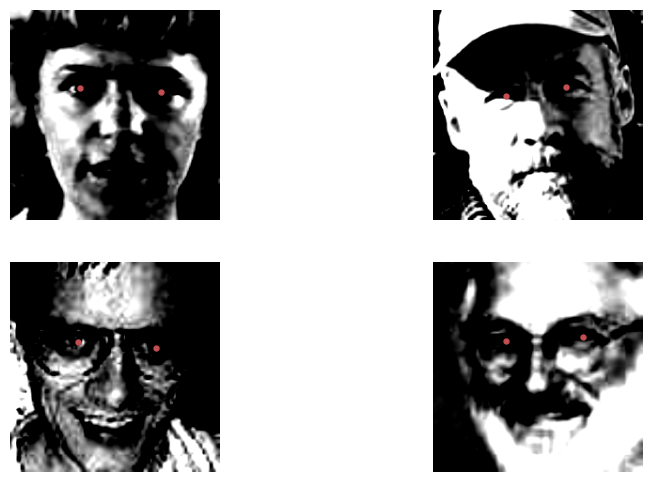

In [15]:
look = next(iter(train_dataloader))
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    coord_x = look[1][i][:2].numpy()
    coord_y = look[1][i][2:].numpy()
    plt.scatter(coord_x, coord_y, s=50, marker='.', c='r')
#     print(look[1][i])
    plt.xlim(0, IMG_SIZE)
    plt.ylim(IMG_SIZE, 0)
plt.show();

**Судя по пропускам в файле с аннотациями и тому что видно на пробных изображениях, разметка местами неточная. Чтоже, посмотрим, что из этого получится**

## Модель для предсказания координат глаз

В качестве feature extractor используется efficient net, к которой вмесо слоя-классификатора присоединен регрессионный слой для предсказания координат опорных точек лица

**[Источник вдохновения](https://medium.com/@oleg.belkovskiy/mastering-facial-keypoint-detection-a-comprehensive-transfer-learning-solution-with-pytorch-2c4a88fc6c2d)**

In [16]:
class MyModel(nn.Module):

    def __init__(self, num_keypoints=4, grad_from = 3):
        super(MyModel, self).__init__()
        self.effnet = models.efficientnet_b0(pretrained=True) 
        self.n_ouputs_last_layer = 1280*7*7

        for name, param in self.effnet.features.named_parameters():
            if int(name.split('.')[0])<grad_from:
                param.requires_grad = False


        self.regressor = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(self.n_ouputs_last_layer, num_keypoints),
        )

    def forward(self, x):
        x = self.effnet.features(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)

        return x

model = MyModel()
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 71.6MB/s]


## Функции для обучения и предсказаний

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        processed_data += inputs.size(0)

    train_loss = (running_loss / processed_data) ** 0.5 
    return train_loss

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item()
        processed_size += inputs.size(0)
    val_loss = (running_loss / processed_size) ** 0.5 
    return val_loss


In [19]:
def trainer(train, val, model, epochs, optimizer, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        sch = lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5, threshold=0.03, min_lr=1e-5)
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train, criterion, opt)

            val_loss = eval_epoch(model, val, criterion)
            sch.step(val_loss)
            history.append((train_loss, val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss))

    return history

In [20]:
def vizualize(h):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("RMSE loss")
    plt.show()

In [21]:
criterion = nn.MSELoss(reduction="sum")
lr_f = 0.0002
lr_reg = 0.0005

optimizer = optim.Adam([
    {'params': model.effnet.features.parameters(), 'lr': lr_f},
    {'params': model.regressor.parameters(), 'lr': lr_reg}
])

In [22]:
history = trainer(train_dataloader, valid_dataloader, model=model, epochs=30, optimizer=optimizer, criterion=criterion)

epoch:   3%|▎         | 1/30 [01:15<36:33, 75.64s/it]


Epoch 001 train_loss: 35.9098     val_loss 13.3544


epoch:   7%|▋         | 2/30 [01:46<23:02, 49.36s/it]


Epoch 002 train_loss: 12.6448     val_loss 14.2200


epoch:  10%|█         | 3/30 [02:17<18:27, 41.01s/it]


Epoch 003 train_loss: 11.0362     val_loss 10.8193


epoch:  13%|█▎        | 4/30 [02:48<16:01, 36.99s/it]


Epoch 004 train_loss: 9.1578     val_loss 8.3694


epoch:  17%|█▋        | 5/30 [03:19<14:28, 34.72s/it]


Epoch 005 train_loss: 8.7185     val_loss 6.9439


epoch:  20%|██        | 6/30 [03:50<13:22, 33.42s/it]


Epoch 006 train_loss: 8.7561     val_loss 6.9290


epoch:  23%|██▎       | 7/30 [04:21<12:30, 32.64s/it]


Epoch 007 train_loss: 7.6336     val_loss 6.2572


epoch:  27%|██▋       | 8/30 [04:53<11:54, 32.46s/it]


Epoch 008 train_loss: 7.2471     val_loss 7.0565


epoch:  30%|███       | 9/30 [05:24<11:15, 32.17s/it]


Epoch 009 train_loss: 6.9489     val_loss 6.5575


epoch:  33%|███▎      | 10/30 [05:55<10:36, 31.82s/it]


Epoch 010 train_loss: 7.2797     val_loss 6.7505


epoch:  37%|███▋      | 11/30 [06:26<09:58, 31.49s/it]


Epoch 011 train_loss: 7.3210     val_loss 6.4809


epoch:  40%|████      | 12/30 [06:57<09:23, 31.29s/it]


Epoch 012 train_loss: 7.2595     val_loss 7.0245


epoch:  43%|████▎     | 13/30 [07:28<08:49, 31.17s/it]


Epoch 013 train_loss: 6.2356     val_loss 6.2145


epoch:  47%|████▋     | 14/30 [07:59<08:19, 31.21s/it]


Epoch 014 train_loss: 5.8436     val_loss 6.0193


epoch:  50%|█████     | 15/30 [08:30<07:46, 31.11s/it]


Epoch 015 train_loss: 5.9559     val_loss 5.7556


epoch:  53%|█████▎    | 16/30 [09:01<07:14, 31.05s/it]


Epoch 016 train_loss: 5.7155     val_loss 5.7242


epoch:  57%|█████▋    | 17/30 [09:32<06:42, 30.98s/it]


Epoch 017 train_loss: 5.6814     val_loss 6.1998


epoch:  60%|██████    | 18/30 [10:03<06:13, 31.11s/it]


Epoch 018 train_loss: 5.5507     val_loss 5.7696


epoch:  63%|██████▎   | 19/30 [10:35<05:43, 31.26s/it]


Epoch 019 train_loss: 5.2530     val_loss 6.0016


epoch:  67%|██████▋   | 20/30 [11:05<05:11, 31.11s/it]


Epoch 020 train_loss: 5.2351     val_loss 5.7142


epoch:  70%|███████   | 21/30 [11:36<04:39, 31.05s/it]


Epoch 021 train_loss: 4.8950     val_loss 5.6571


epoch:  73%|███████▎  | 22/30 [12:07<04:08, 31.03s/it]


Epoch 022 train_loss: 4.6858     val_loss 5.5993


epoch:  77%|███████▋  | 23/30 [12:38<03:36, 30.97s/it]


Epoch 023 train_loss: 4.4717     val_loss 5.5332


epoch:  80%|████████  | 24/30 [13:09<03:05, 30.95s/it]


Epoch 024 train_loss: 4.4893     val_loss 5.7773


epoch:  83%|████████▎ | 25/30 [13:40<02:34, 30.95s/it]


Epoch 025 train_loss: 4.4639     val_loss 5.7047


epoch:  87%|████████▋ | 26/30 [14:11<02:03, 30.87s/it]


Epoch 026 train_loss: 4.3747     val_loss 5.9209


epoch:  90%|█████████ | 27/30 [14:42<01:32, 30.89s/it]


Epoch 027 train_loss: 4.4100     val_loss 5.6563


epoch:  93%|█████████▎| 28/30 [15:13<01:02, 31.10s/it]


Epoch 028 train_loss: 4.3613     val_loss 5.5630


epoch:  97%|█████████▋| 29/30 [15:44<00:31, 31.13s/it]


Epoch 029 train_loss: 4.0509     val_loss 5.5939


epoch: 100%|██████████| 30/30 [16:15<00:00, 32.53s/it]


Epoch 030 train_loss: 4.0896     val_loss 5.6163


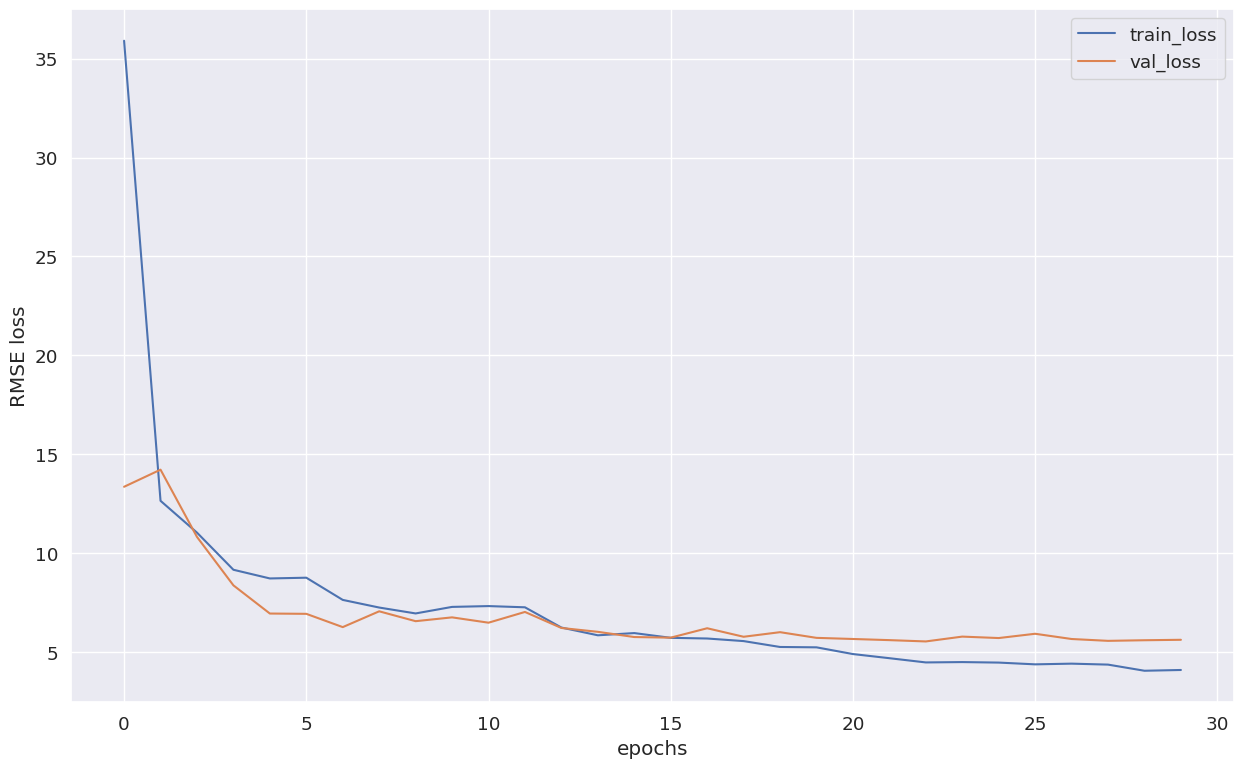

In [23]:
vizualize(history)

In [24]:
torch.save(model.state_dict(), outDir + '/' + 'enet_reg.pth')

## Предсказания на тестовой выборке

In [25]:
trained_model = model.to(device)
trained_model.load_state_dict(torch.load(outDir + '/' + 'enet_reg.pth'))

<All keys matched successfully>

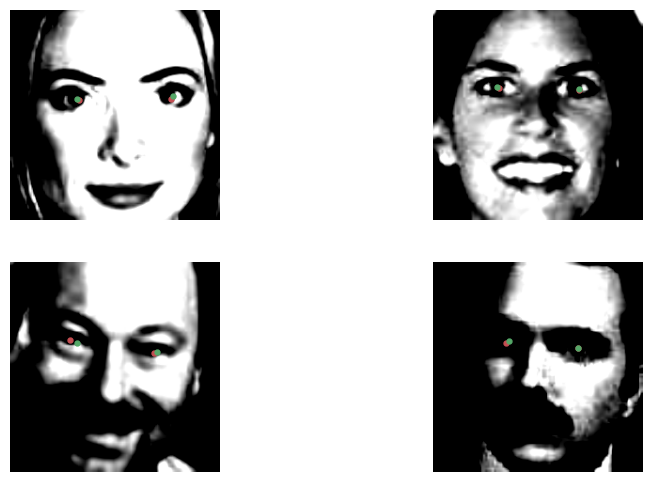

In [27]:
look = next(iter(test_dataloader))
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
#     plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    coord_x = look[1][i][:2].numpy()
    coord_y = look[1][i][2:].numpy()
    with torch.no_grad():
        preds = trained_model(look[0][i].unsqueeze(0).to(device))
        pr_coord_x = preds[0][:2].cpu().numpy()
        pr_coord_y = preds[0][2:].cpu().numpy()
    plt.scatter(coord_x, coord_y, s=50, marker='.', c='r')
    plt.scatter(pr_coord_x, pr_coord_y, s=50, marker='.', c='g')
    plt.axis('off')
    plt.xlim(0, IMG_SIZE)
    plt.ylim(IMG_SIZE, 0)
plt.show();

## Функция для выравнивания изображений из детектированных bboxes

- ресайз изображения, чтобы расстояние между зрачками при размере изображения 128х128 (без учета паддинга - 60х120) стало примерно равно 64px (как было в изображениях из 3-ей части, на которых учился классификатор)
- поворот изображения на угол,такой чтобы зрачки оказались на горизонтальной прямой

In [28]:
rawDir = '/kaggle/input/face-to-crop/raw_faces/'

In [77]:
def crop(img, preds):
    coord_x = preds[0][:2].cpu().numpy()
    coord_y = preds[0][2:].cpu().numpy()
    dist = abs(coord_x[0] - coord_x[1])
    delta = abs(coord_y[0] - coord_y[1])
    angle = np.arctan(delta / dist) * 180 / np.pi
    img = transforms.functional.rotate(img, -angle)
    k = int(60 * (64 / dist))
    new_size = (k * img.size()[1], 120)
    crop_1 = transforms.CenterCrop(new_size)
    img = crop_1(img)
    crop_2 = transforms.CenterCrop((128, 128))
    img = crop_2(img)
    return img

In [37]:
transformer_1 = transforms.Compose([transforms.ToTensor(),
                    transforms.Resize((IMG_SIZE,IMG_SIZE), antialias=True)
                                 ])

Далеко не все лица из детектированных в принципе хорошо различимы, вот наиболее показательные примеры. Также в исходном обучающем датасете не было лиц, повернутых на большой угол, что также сказалось на качестве предсказаний опорных точек

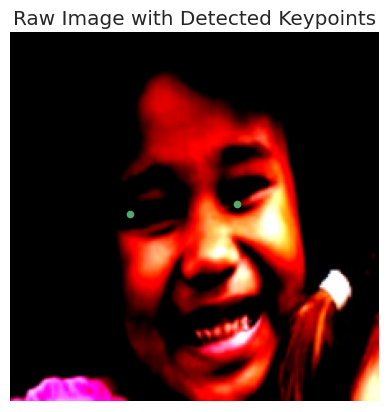

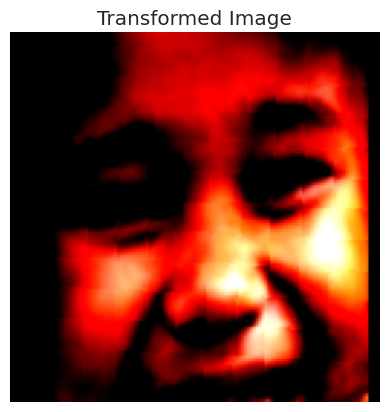

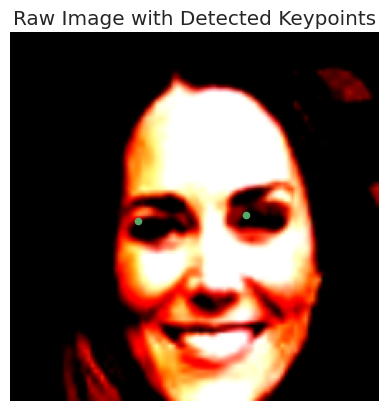

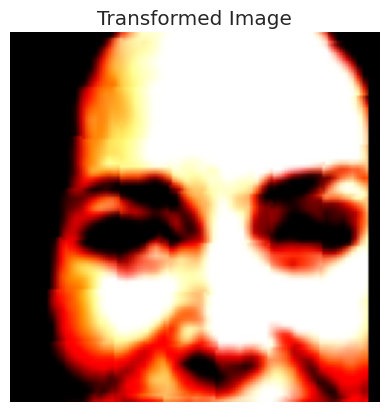

In [91]:
ind = np.random.randint(0, len(os.listdir(rawDir)), 2)
for i in range(len(ind)):
    image = Image.open(os.path.join(rawDir, os.listdir(rawDir)[ind[i]]))
    image = transformer_1(image)
    plt.title('Raw Image with Detected Keypoints')
    plt.imshow(image.permute(1,2,0))
    with torch.no_grad():
        preds = trained_model(image.unsqueeze(0).to(device))
    pr_coord_x = preds[0][:2].cpu().numpy()
    pr_coord_y = preds[0][2:].cpu().numpy()
    plt.scatter(pr_coord_x, pr_coord_y, s=80, marker='.', c='g')
    plt.axis('off')
    plt.xlim(0, IMG_SIZE)
    plt.ylim(IMG_SIZE, 0)
    plt.show()
    plt.title('Transformed Image')
    plt.imshow(crop(image, preds).permute(1,2,0))
    plt.axis('off')
    plt.show()
#     print(crop(image, preds).shape)

In [50]:
pr_coord_y

array([121.87356, 126.92949], dtype=float32)

## В результате обучена модель на посик ключевых точек лица, реализован поворот и обрезка изображений из результатов детекции лиц. 

Есть недочеты в точности предсказаний, что объясняется особенностями исходного датасета (практически все лица повернуты ровно)